# Project 4 : West-Nile-Virus-Prediction

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Further Data Cleaning](#Further-Data-Cleaning)
- [EDA](#EDA)
- [PICKLE](#Pickle)


## Background


https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/





The common house mosquito, Culex pipiens (Diptera: Culicidae), which is considered the primary bridge vector of West Nile Virus (WNV) to humans, is a wide spread insect pest with medical importance and consists of two distinct bioforms, Cx. pipiens f. pipiens and Cx. pipiens f. molestus. Here, we consider the adult lifespan of male and female Cx. pipiens f. pipiens under controlled conditions at five constant temperature regimes (15, 20, 25, 27.5, and 30 °C). Our results show that adult longevity was affected by temperature, as it significantly decreased with increase in temperature. At the highest tested temperature, mean adult longevity did not exceed 12 days for both sexes and thus makes impossible the risk of WNV transmission. On the other hand at the lowest temperature, longevity was extremely high with some individuals surviving up to 129 and 132 days, males and females, respectively, and thus enable them to function as potential vectors of WNV for a prolonged period of time. As far as sex is concerned, adult females displayed a 1.2–1.4-fold longer longevity compared to the male ones. However, this difference was significant only at the lowest and highest tested temperature regime. This information is useful in determining the critical temperatures which may affect the distribution of Cx. pipiens and consequently the risk of WNV transmission. Moreover, the effect of environmental temperature should be considered when evaluating the abundance of these species.
https://link.springer.com/article/10.1007/s00436-014-4152-x



https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-6-129

Background Culex pipiens/restuans mosquitoes are important vectors for a variety of arthropod borne viral infections. In this study, the associations between 20 years of mosquito capture data and the time lagged environmental quantities daytime length, temperature, precipitation, relative humidity and wind speed were used to generate a predictive model for the population dynamics of this vector species. Methods Mosquito population in the study area was represented by averaged time series of mosquitos counts captured at 6 sites in Cook County (Illinois, USA). Cross-correlation maps (CCMs) were compiled to investigate the association between mosquito abundances and environmental quantities. The results obtained from the CCMs were incorporated into a Poisson regression to generate a predictive model. To optimize the predictive model the time lags obtained from the CCMs were adjusted using a genetic algorithm. Results CCMs for weekly data showed a highly positive correlation of mosquito abundances with daytime length 4 to 5 weeks prior to capture (quantified by a Spearman rank order correlation of r S  = 0. 898) and with temperature during 2 weeks prior to capture (r S  = 0. 870). Maximal negative correlations were found for wind speed averaged over 3 week prior to capture (r S  = − 0. 621). Cx. pipiens/restuans population dynamics was predicted by integrating the CCM results in Poisson regression models. They were used to simulate the average seasonal cycle of the mosquito abundance. Verification with observations resulted in a correlation of r S  = 0. 899 for daily and r S  = 0. 917 for weekly data. Applying the optimized models to the entire 20-years time series also resulted in a suitable fit with r S  = 0. 876 for daily and r S  = 0. 899 for weekly data. Conclusions The study demonstrates the application of interval lagged weather data to predict mosquito abundances with a feasible accuracy, especially when related to weekly Cx. pipiens/restuans populations.


# Import Libraries

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [2]:
#steps to install geopandas


#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#pip install contextily

In [3]:
#!pip install imblearn

In [4]:
#!pip install lightgbm

# define some functions

In [5]:
#the fuction will 
#1. plot neighborhoods map of chicago
#2. plot 2 weather stations on the map
#3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'
def plot_geodata(dict_df   # dictionary containing dataframe and its name  
                ):
    colors = ['black','orange','red','yellow']
    markersizes = [3,1, 14,  5]
    zorders = [4,1,3,2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    #plot neighborhoods map of chicago
    geojson_file = '../assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    #plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude','Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='purple', markersize=20,zorder=5, label="weather stations")
    
    #plot input dataframes
    i=0
    for label_df,df in dict_df.items():
        color_ = colors[i]
        
        #if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']
        else:
            markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=5)
    plt.show()
    return 

# Data Import and Cleaning

**train data** 

In [6]:
df_train = pd.read_csv("../assets/train.csv")

In [7]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0


In [8]:
df_train.groupby('Species').count()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Species,,,,,,,,,,,
CULEX ERRATICUS,1,1,1,1,1,1,1,1,1,1,1
CULEX PIPIENS,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699
CULEX PIPIENS/RESTUANS,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752
CULEX RESTUANS,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740
CULEX SALINARIUS,86,86,86,86,86,86,86,86,86,86,86
CULEX TARSALIS,6,6,6,6,6,6,6,6,6,6,6
CULEX TERRITANS,222,222,222,222,222,222,222,222,222,222,222


In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,"10,506.00",35.69,24.34,10.00,12.00,33.00,52.00,98.00
Latitude,"10,506.00",41.84,0.11,41.64,41.73,41.85,41.95,42.02
Longitude,"10,506.00",-87.70,0.10,-87.93,-87.76,-87.69,-87.63,-87.53
AddressAccuracy,"10,506.00",7.82,1.45,3.00,8.00,8.00,9.00,9.00
NumMosquitos,"10,506.00",12.85,16.13,1.00,2.00,5.00,17.00,50.00
WnvPresent,"10,506.00",0.05,0.22,0.00,0.00,0.00,0.00,1.00


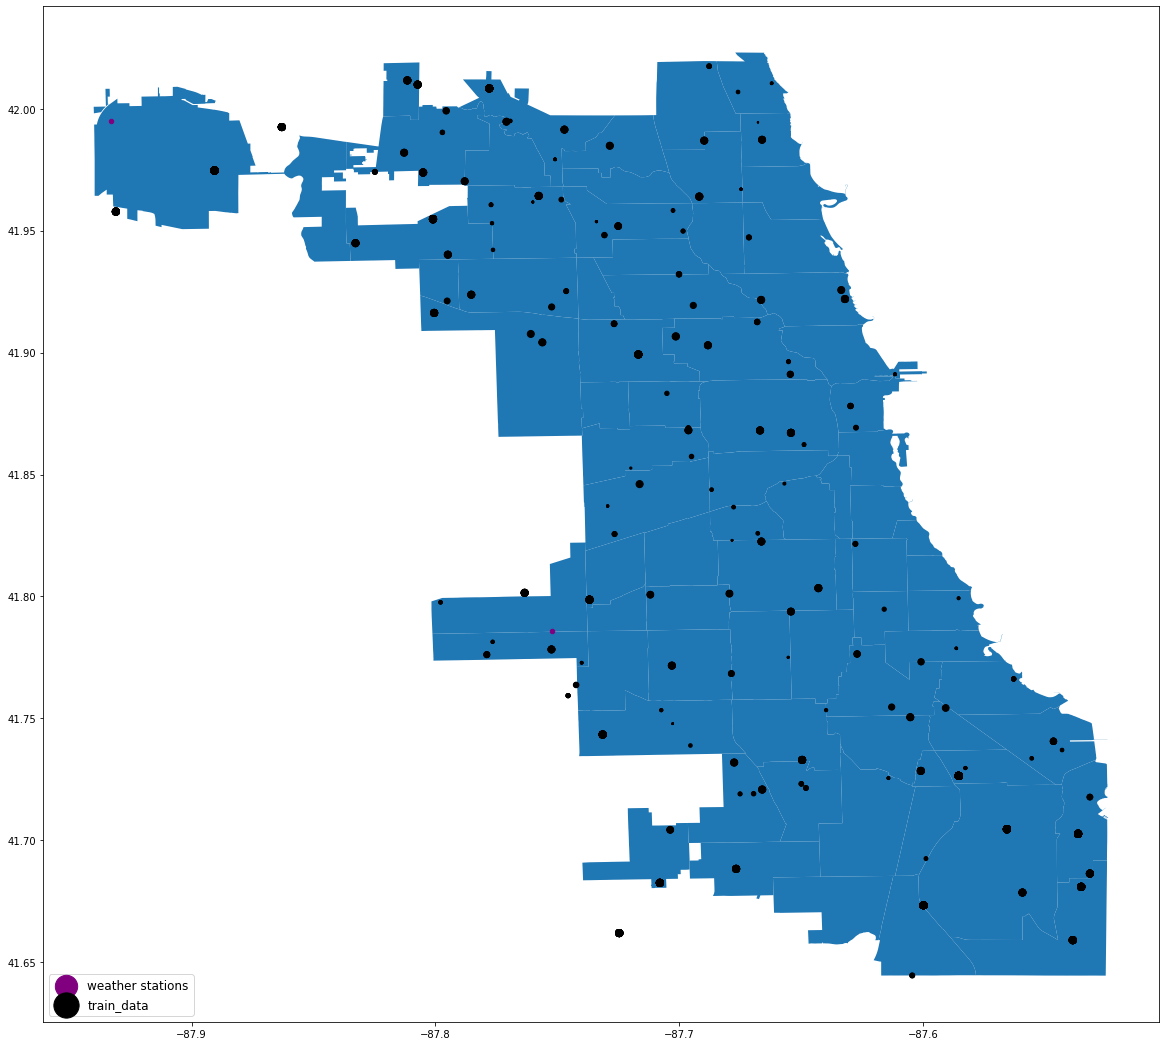

In [10]:
#plot data to the map
dict_df = {'train_data':df_train           
          }
plot_geodata(dict_df)

#### spray data

In [11]:
df_spray = pd.read_csv("../assets/spray.csv")
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.39,-88.09
1,2011-08-29,6:57:08 PM,42.39,-88.09
2,2011-08-29,6:57:18 PM,42.39,-88.09
3,2011-08-29,6:57:28 PM,42.39,-88.09
4,2011-08-29,6:57:38 PM,42.39,-88.09


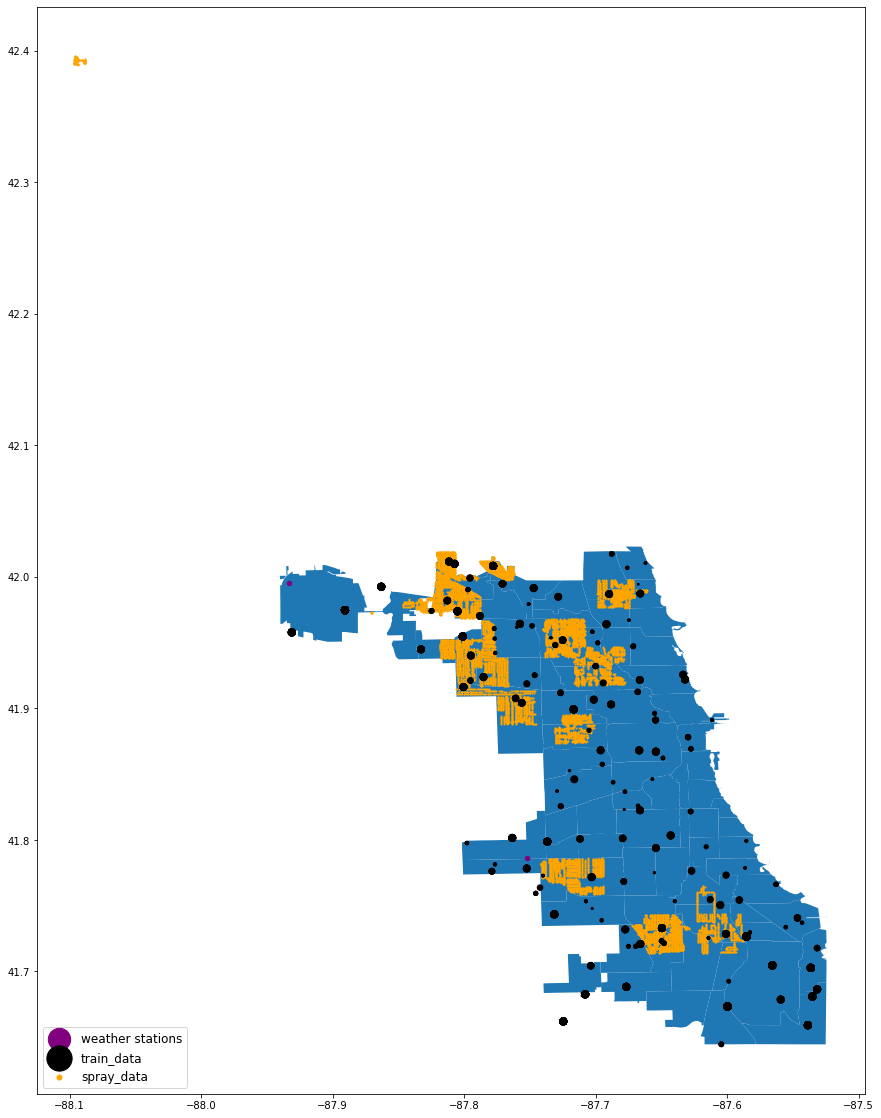

In [12]:
dict_df = {'train_data':df_train, 
           'spray_data':df_spray,
           
           
          }
plot_geodata(dict_df)


**we only consider the spray data close to those traps, whose latitude are all below 42.3**

In [13]:
df_spray = df_spray.query("Latitude < 42.3")

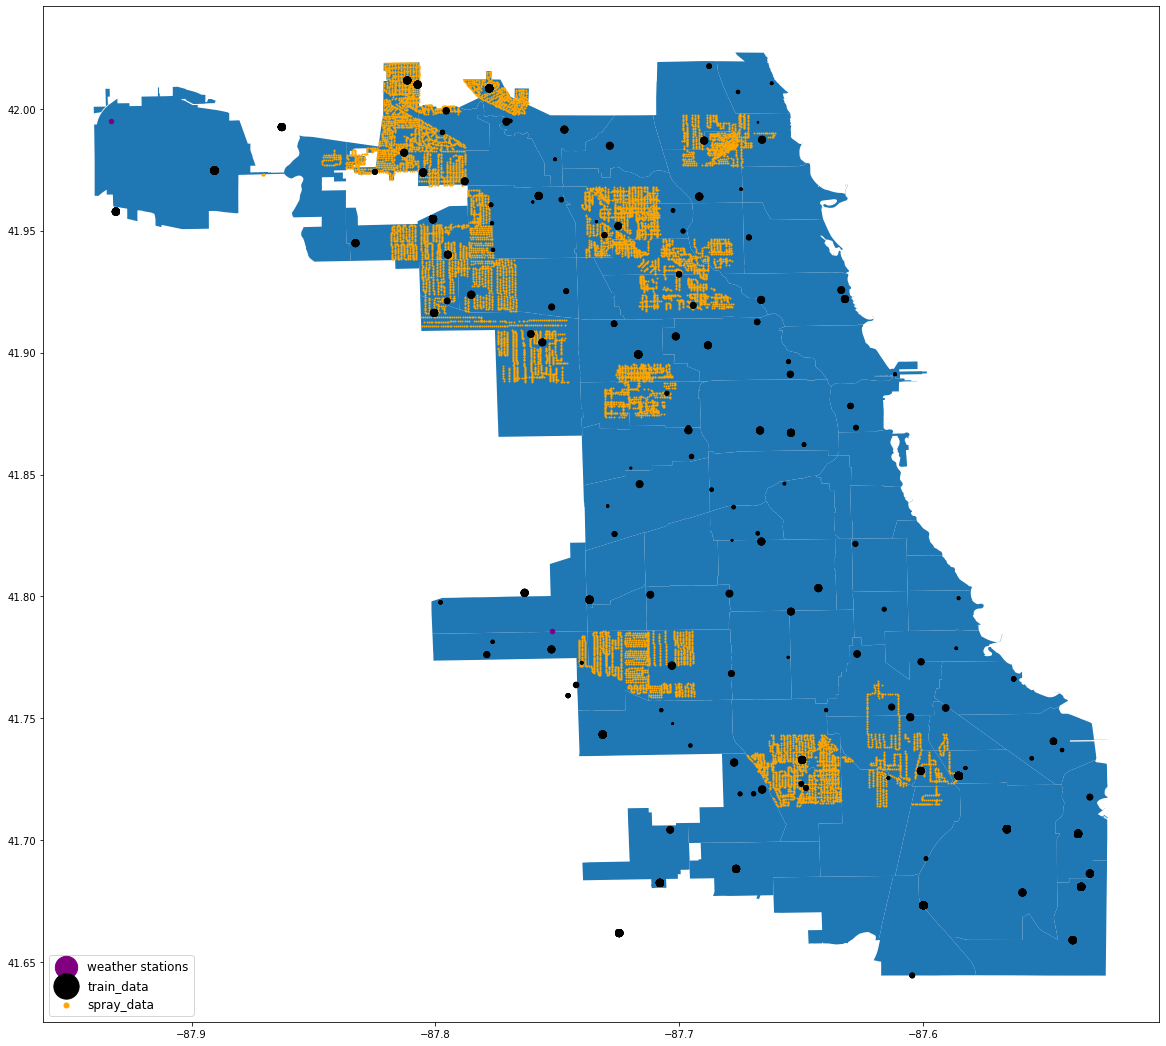

In [14]:
#plot data to the map
dict_df = {'train_data':df_train, 
           'spray_data':df_spray,
           
           
          }
plot_geodata(dict_df)


#### test data

In [15]:
df_test = pd.read_csv("../assets/test.csv")
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9


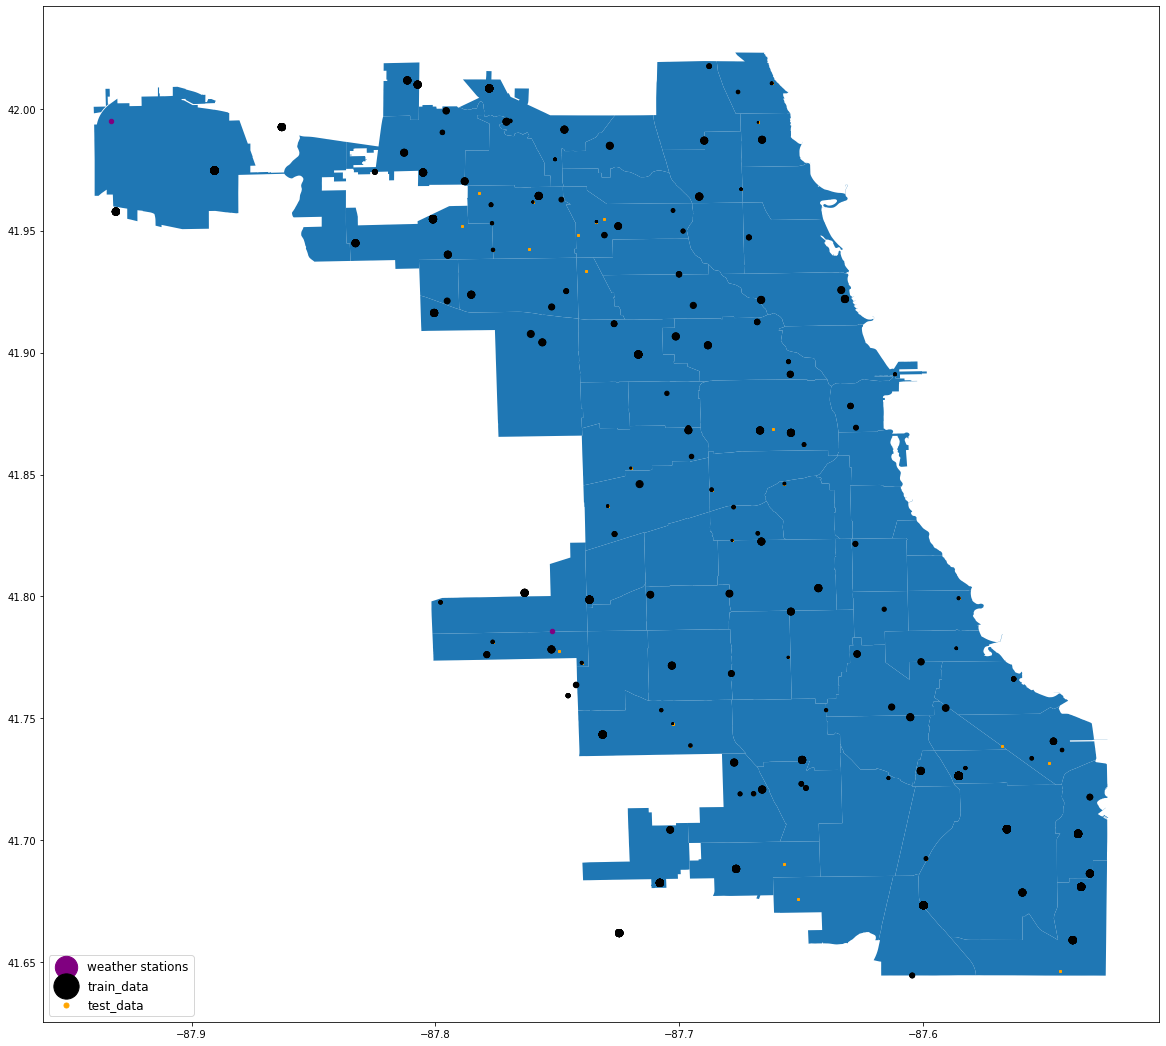

In [16]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
          }
plot_geodata(dict_df)


#### weather data

In [17]:
df_weather = pd.read_csv("../assets/weather.csv")
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.70,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9


# Further Data Cleaning
We will check and handle:
- null values
- invalid values
- potential outliers

#### **df_train**

In [18]:
#check null values
df_train.isnull().sum().sort_values(ascending=False)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
geometry                  0
dtype: int64

In [19]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Date                    10506 non-null  object  
 1   Address                 10506 non-null  object  
 2   Species                 10506 non-null  object  
 3   Block                   10506 non-null  int64   
 4   Street                  10506 non-null  object  
 5   Trap                    10506 non-null  object  
 6   AddressNumberAndStreet  10506 non-null  object  
 7   Latitude                10506 non-null  float64 
 8   Longitude               10506 non-null  float64 
 9   AddressAccuracy         10506 non-null  int64   
 10  NumMosquitos            10506 non-null  int64   
 11  WnvPresent              10506 non-null  int64   
 12  geometry                10506 non-null  geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 1.0+ MB


In [20]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

**clean df_test**

In [21]:
df_test.isnull().sum().sort_values(ascending=False)

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
geometry                  0
dtype: int64

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Id                      116293 non-null  int64   
 1   Date                    116293 non-null  object  
 2   Address                 116293 non-null  object  
 3   Species                 116293 non-null  object  
 4   Block                   116293 non-null  int64   
 5   Street                  116293 non-null  object  
 6   Trap                    116293 non-null  object  
 7   AddressNumberAndStreet  116293 non-null  object  
 8   Latitude                116293 non-null  float64 
 9   Longitude               116293 non-null  float64 
 10  AddressAccuracy         116293 non-null  int64   
 11  geometry                116293 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(6)
memory usage: 10.6+ MB


In [23]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  geometry                116293 non-null  geometry      
dtypes: datetime64[ns](1), float64(

**clean df_spray**

In [24]:
df_spray.isnull().sum().sort_values(ascending=False)

Time         584
Date           0
Latitude       0
Longitude      0
geometry       0
dtype: int64

In [25]:
df_spray.shape

(14740, 5)

In [26]:
df_spray.head(20)

,Date,Time,Latitude,Longitude,geometry
95,2011-09-07,7:52:52 PM,41.98,-87.79,POINT (-87.78778 41.98143)
96,2011-09-07,7:53:02 PM,41.98,-87.79,POINT (-87.78778 41.98100)
97,2011-09-07,7:53:12 PM,41.98,-87.79,POINT (-87.78776 41.98056)
98,2011-09-07,7:53:22 PM,41.98,-87.79,POINT (-87.78776 41.98020)
99,2011-09-07,7:53:32 PM,41.98,-87.79,POINT (-87.78776 41.97975)
100,2011-09-07,7:53:42 PM,41.98,-87.79,POINT (-87.78775 41.97935)
101,2011-09-07,7:53:52 PM,41.98,-87.79,POINT (-87.78776 41.97885)
102,2011-09-07,7:54:02 PM,41.98,-87.79,POINT (-87.78777 41.97840)
103,2011-09-07,7:54:12 PM,41.98,-87.79,POINT (-87.78776 41.97799)
104,2011-09-07,7:54:22 PM,41.98,-87.79,POINT (-87.78778 41.97749)


In [27]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Date       14740 non-null  object  
 1   Time       14156 non-null  object  
 2   Latitude   14740 non-null  float64 
 3   Longitude  14740 non-null  float64 
 4   geometry   14740 non-null  geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 690.9+ KB


In [28]:
df_spray['Date']=pd.to_datetime(df_spray['Date'])
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14740 non-null  datetime64[ns]
 1   Time       14156 non-null  object        
 2   Latitude   14740 non-null  float64       
 3   Longitude  14740 non-null  float64       
 4   geometry   14740 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(1)
memory usage: 690.9+ KB


**clean df_weather**

In [29]:
df_weather.isnull().sum().sort_values(ascending=False)

Station        0
Date           0
ResultDir      0
ResultSpeed    0
SeaLevel       0
StnPressure    0
PrecipTotal    0
SnowFall       0
Water1         0
Depth          0
CodeSum        0
Sunset         0
Sunrise        0
Cool           0
Heat           0
WetBulb        0
DewPoint       0
Depart         0
Tavg           0
Tmin           0
Tmax           0
AvgSpeed       0
dtype: int64

In [30]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [31]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [32]:
df_weather['Tavg'].value_counts()

73    138
77    117
70    117
75    110
71    109
74    107
72    104
69    103
78    102
76    100
68     99
79     98
66     93
67     89
61     88
64     86
80     84
65     84
63     81
57     67
62     66
60     61
50     57
81     55
53     49
58     49
54     48
82     48
55     48
56     46
52     46
59     45
51     36
83     34
49     29
45     28
47     24
46     24
84     21
44     19
48     17
85     16
86     16
42     15
43     12
M      11
87      9
41      7
40      5
39      4
89      4
88      4
91      4
37      2
38      2
90      2
36      2
92      1
93      1
94      1
Name: Tavg, dtype: int64

In [33]:
df_weather.query("Tavg == 'M'")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.10,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.40,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0.00,29.30,29.96,10.90,33,11.0
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.80,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0.00,29.39,M,4.70,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0.00,29.51,30.17,15.80,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0.00,29.33,30.00,5.80,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.30,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.10,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.70,23,11.9


In [34]:
df_weather['Tavg']=np.where(df_weather['Tavg']=='M', (df_weather['Tmax']+df_weather['Tmin'])/2, df_weather['Tavg'])
df_weather['Tavg']=df_weather['Tavg'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [35]:
df_weather['Water1'].value_counts()

M    2944
Name: Water1, dtype: int64

In [36]:
df_weather['PrecipTotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
0.04      36
0.05      32
0.08      28
0.12      28
0.06      27
0.07      23
0.16      21
0.09      21
0.11      20
0.14      20
0.17      17
0.28      15
0.13      14
0.19      14
0.18      14
0.20      13
0.15      13
0.23      11
0.25      11
0.26      11
0.10      10
0.24      10
0.31       9
0.39       9
0.40       9
0.21       9
0.29       9
0.43       9
0.34       8
0.32       8
0.22       8
0.33       7
0.41       7
0.50       7
0.48       7
0.37       7
0.45       7
0.59       7
0.30       7
0.80       6
0.63       6
0.84       6
0.65       6
0.27       6
0.92       5
0.68       5
0.44       5
0.36       5
0.54       5
0.93       5
0.85       5
1.23       4
0.72       4
0.75       4
0.64       4
0.52       4
0.70       4
0.55       4
0.97       4
0.51       4
0.58       4
0.89       4
0.66       4
0.87       3
0.60       3
1.31       3
1.05       3
1.01       3
0.77       3
1.03       3
0.56       3
0.88       3

Special symbols

Symbols that appear on many of the individual summaries: (*) less than one half; (T ) trace, an amount too small to measure; (—) below zero temperatures are preceded by a minus sign.
Weather averages year-by-year

PRECIPITATION refers to the inches of water equivalent in the total of all forms of liquid or frozen precipitation that fell during each month. Snowfall refers to the actual amount of snow in inches that fell during the month. T (trace) is a precipitation amount of less than 0.005 in (note: in estimating the water equivalent of snow a ratio of 10 in of snow equal 1 in of water is customarily employed).
https://www.encyclopedia.com/environment/encyclopedias-almanacs-transcripts-and-maps/local-climatological-data-reports


In [37]:
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='T', 0.005, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='M', 0, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=df_weather['PrecipTotal'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

**split df_weather into 2 dataframes according to weather stations**

In [38]:
df_weather_1=df_weather.query("Station == 1")
df_weather_1.set_index("Date", inplace=True)
df_weather_1.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.00,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
2007-05-02,1,59,42,51.00,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
2007-05-03,1,66,46,56.00,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9
2007-05-04,1,66,49,58.00,4,41,50,7,0,0444,1852,RA,0,M,0.0,0.01,29.31,30.05,10.40,8,10.8
2007-05-05,1,66,53,60.00,5,38,49,5,0,0443,1853,,0,M,0.0,0.01,29.40,30.10,11.70,7,12.0


**try to find out the day lenght for 2 stations**

**df_weather_1**

In [39]:
#convert datatype
df_weather_1['Sunset'] = df_weather_1['Sunset'].astype(int)

In [40]:
df_weather_1['Sunrise'].value_counts()

0416    104
0417     64
0419     40
0420     32
0418     32
0422     32
0425     32
0421     24
0423     24
0433     24
0428     24
0429     16
0447     16
0424     16
0426     16
0427     16
0448     16
0430     16
0439     16
0446     16
0431     16
0444     16
0443     16
0441     16
0442     16
0438     16
0437     16
0436     16
0435     16
0434     16
0432     16
0555      8
0546      8
0554      8
0553      8
0552      8
0550      8
0549      8
0548      8
0547      8
0539      8
0545      8
0544      8
0543      8
0542      8
0541      8
0540      8
0538      8
0537      8
0536      8
0557      8
0556      8
0614      8
0558      8
0559      8
0622      8
0620      8
0619      8
0618      8
0617      8
0616      8
0533      8
0613      8
0612      8
0611      8
0610      8
0608      8
0607      8
0606      8
0605      8
0604      8
0603      8
0602      8
0600      8
0535      8
0517      8
0532      8
0508      8
0505      8
0504      8
0503      8
0502      8
0501      8
0500

In [41]:
df_weather_1['Sunrise'] = df_weather_1['Sunrise'].astype(int)
df_weather_1['Day_length'] =((df_weather_1['Sunset']//100*60+df_weather_1['Sunset']%100)
                                 - (df_weather_1['Sunrise']//100*60+df_weather_1['Sunrise']%100)
                               )/60 
df_weather_1[['Sunrise','Sunset','Day_length']].head(10)

,Sunrise,Sunset,Day_length
Date,,,
2007-05-01,448,1849,14.02
2007-05-02,447,1850,14.05
2007-05-03,446,1851,14.08
2007-05-04,444,1852,14.13
2007-05-05,443,1853,14.17
2007-05-06,442,1855,14.22
2007-05-07,441,1856,14.25
2007-05-08,439,1857,14.30
2007-05-09,438,1858,14.33


**df_weather_2**

In [42]:
df_weather_2=df_weather.query("Station == 2")
df_weather_2.set_index("Date", inplace=True)

In [43]:
#copy the 'Sunrise', 'Sunset' and 'Day_length' from df_weather_1 to df_weather_2
df_weather_2.loc[:,'Sunrise'] = np.where(True, df_weather_1['Sunrise'],0)
df_weather_2.loc[:,'Sunset'] = np.where(True,df_weather_1['Sunset'],0)
df_weather_2.loc[:,'Day_length'] = np.where(True,df_weather_1['Day_length'],0)
df_weather_2.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_length
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68.00,M,51,57,0,3,448,1849,,M,M,M,0.00,29.18,29.82,2.70,25,9.6,14.02
2007-05-02,2,60,43,52.00,M,42,47,13,0,447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4,14.05
2007-05-03,2,67,48,58.00,M,40,50,7,0,446,1851,HZ,M,M,M,0.00,29.46,30.12,12.90,6,13.2,14.08
2007-05-04,2,78,51,64.50,M,42,50,M,M,444,1852,,M,M,M,0.00,29.36,30.04,10.10,7,10.4,14.13
2007-05-05,2,66,54,60.00,M,39,50,5,0,443,1853,,M,M,M,0.01,29.46,30.09,11.20,7,11.5,14.17


# EDA
- 

**Mosquito Species Analysis**

In [44]:
df_train['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [45]:
df_test['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

             ploting NumMosquitos and WnvPresent of different species


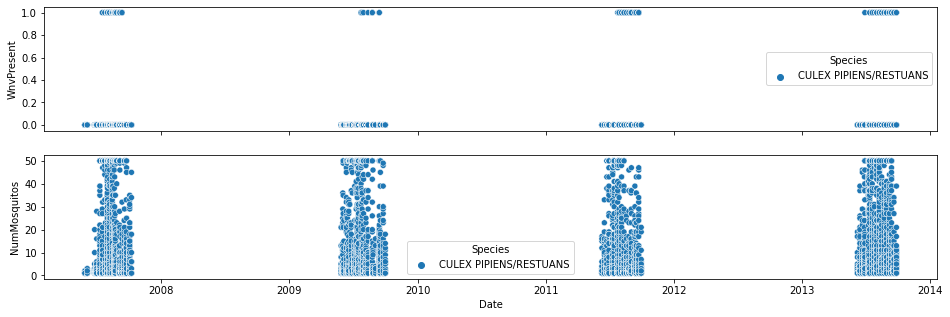

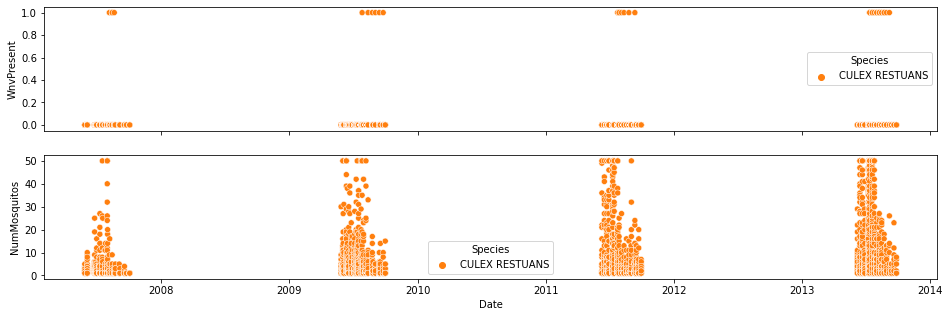

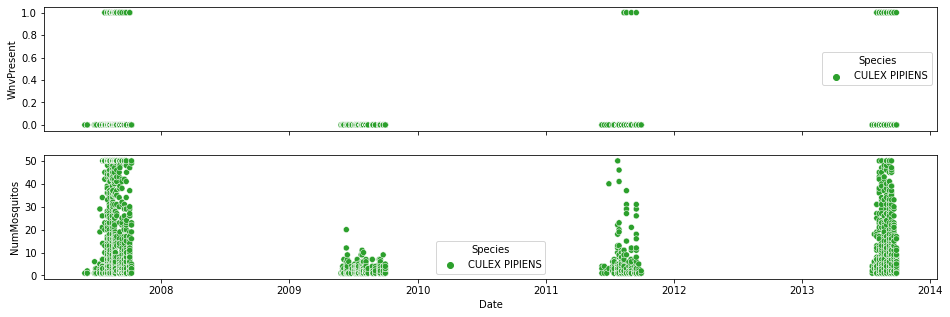

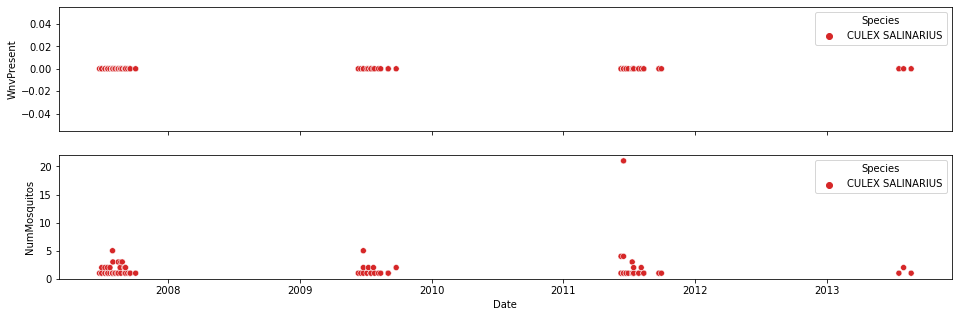

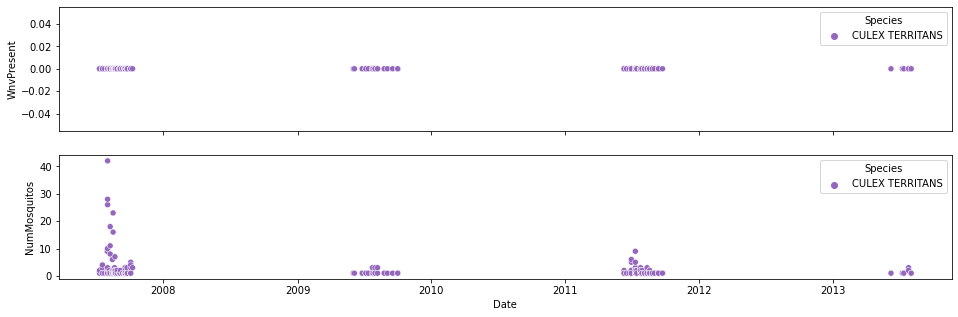

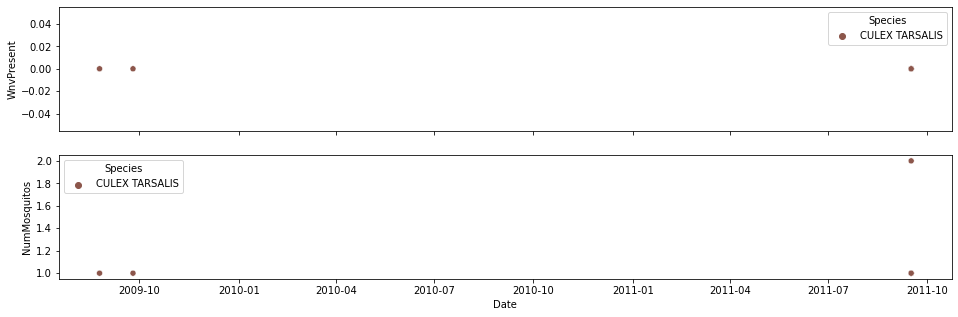

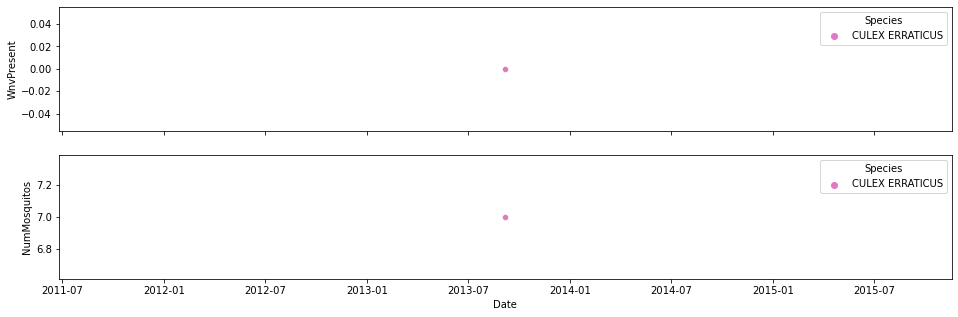

In [46]:
#plot NumMosquitos and WnvPresent of different species
df1 = df_train
df1 = df1.set_index("Date")
species = df1['Species'].unique().tolist()
print('             ploting NumMosquitos and WnvPresent of different species')
for i in range(len(species)):
    df = df1[df1["Species"] == species[i]]
    palette ={'CULEX PIPIENS/RESTUANS': "C0",
              'CULEX RESTUANS': "C1", 
              'CULEX PIPIENS': "C2", 
              'CULEX SALINARIUS': "C3",
              'CULEX TERRITANS': "C4", 
              'CULEX TARSALIS': "C5", 
              'CULEX ERRATICUS': "C6", 
              'UNSPECIFIED CULEX': "C7"
             }
   # print(species[i])
    #palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    fig,ax=plt.subplots(2,sharex='col',figsize=(16,5))
    #df['WnvPresent'].plot(kind='area', ax=ax[0])
    sns.scatterplot(data=df,x=df.index, y='WnvPresent',hue='Species',ax=ax[0],palette=palette)
    #df['NumMosquitos'].plot(kind='area', ax=ax[1])
    sns.scatterplot(data=df,x=df.index, y='NumMosquitos',hue='Species',ax=ax[1],palette=palette)

**Observations**:
- West Nile Virus is founded in 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS' only, thus we can group the other species as one group for convenience
- the popultion of 'CULEX PIPIENS' varied in different years

**NumMosquitos vs. WnvPresent**

In [47]:
df_wnvpresent = df_train.query("WnvPresent==1")
df_not_wnvpresent = df_train.query("WnvPresent==0")

<AxesSubplot:xlabel='NumMosquitos', ylabel='Count'>

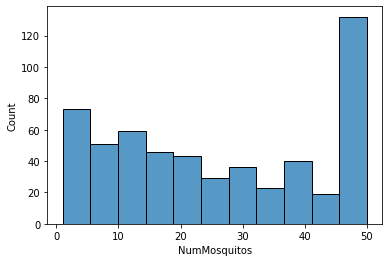

In [48]:
sns.histplot(data=df_wnvpresent, x='NumMosquitos')

<AxesSubplot:xlabel='NumMosquitos', ylabel='Count'>

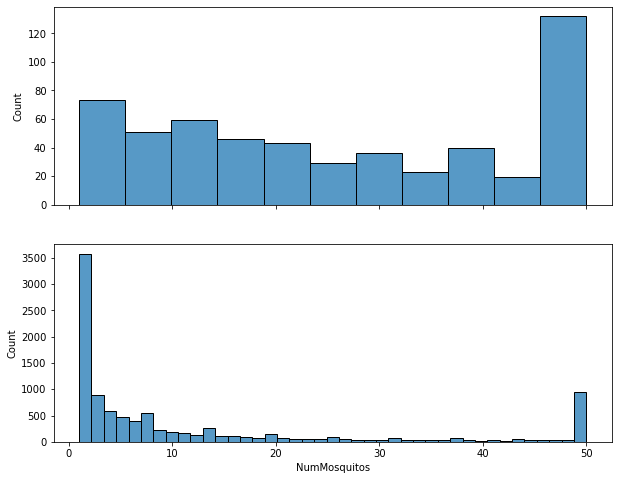

In [49]:
fig,ax=plt.subplots(2,sharex='col',figsize=(10,8))
#df['WnvPresent'].plot(kind='area', ax=ax[0])
sns.histplot(data=df_wnvpresent, x='NumMosquitos',ax=ax[0])
sns.histplot(data=df_not_wnvpresent, x='NumMosquitos',ax=ax[1])

In [50]:
df_train.groupby(['Species']).mean()['WnvPresent']

Species
CULEX ERRATICUS          0.00
CULEX PIPIENS            0.09
CULEX PIPIENS/RESTUANS   0.06
CULEX RESTUANS           0.02
CULEX SALINARIUS         0.00
CULEX TARSALIS           0.00
CULEX TERRITANS          0.00
Name: WnvPresent, dtype: float64

#### EDA df_weather_2

<AxesSubplot:xlabel='Date'>

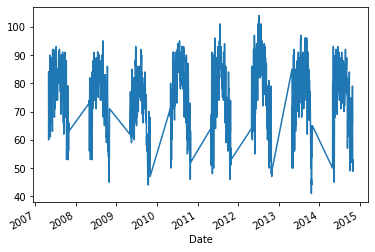

In [51]:
df_weather_2['Tmax'].plot()

<AxesSubplot:xlabel='Date'>

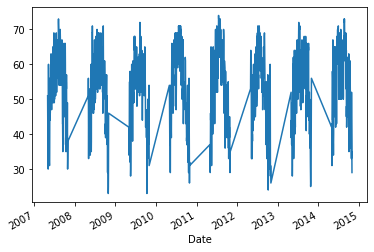

In [52]:
df_weather_2['DewPoint'].plot()

<AxesSubplot:xlabel='Date'>

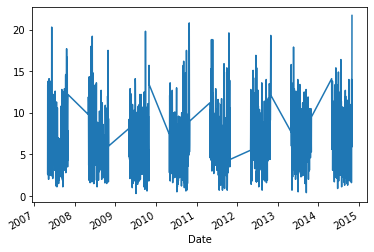

In [53]:
df_weather_2['ResultSpeed'].plot()

<AxesSubplot:xlabel='Date'>

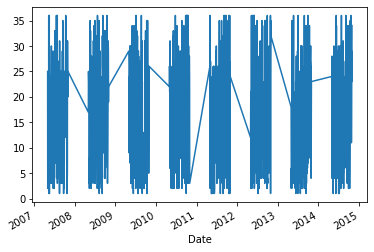

In [54]:
df_weather_2['ResultDir'].plot()

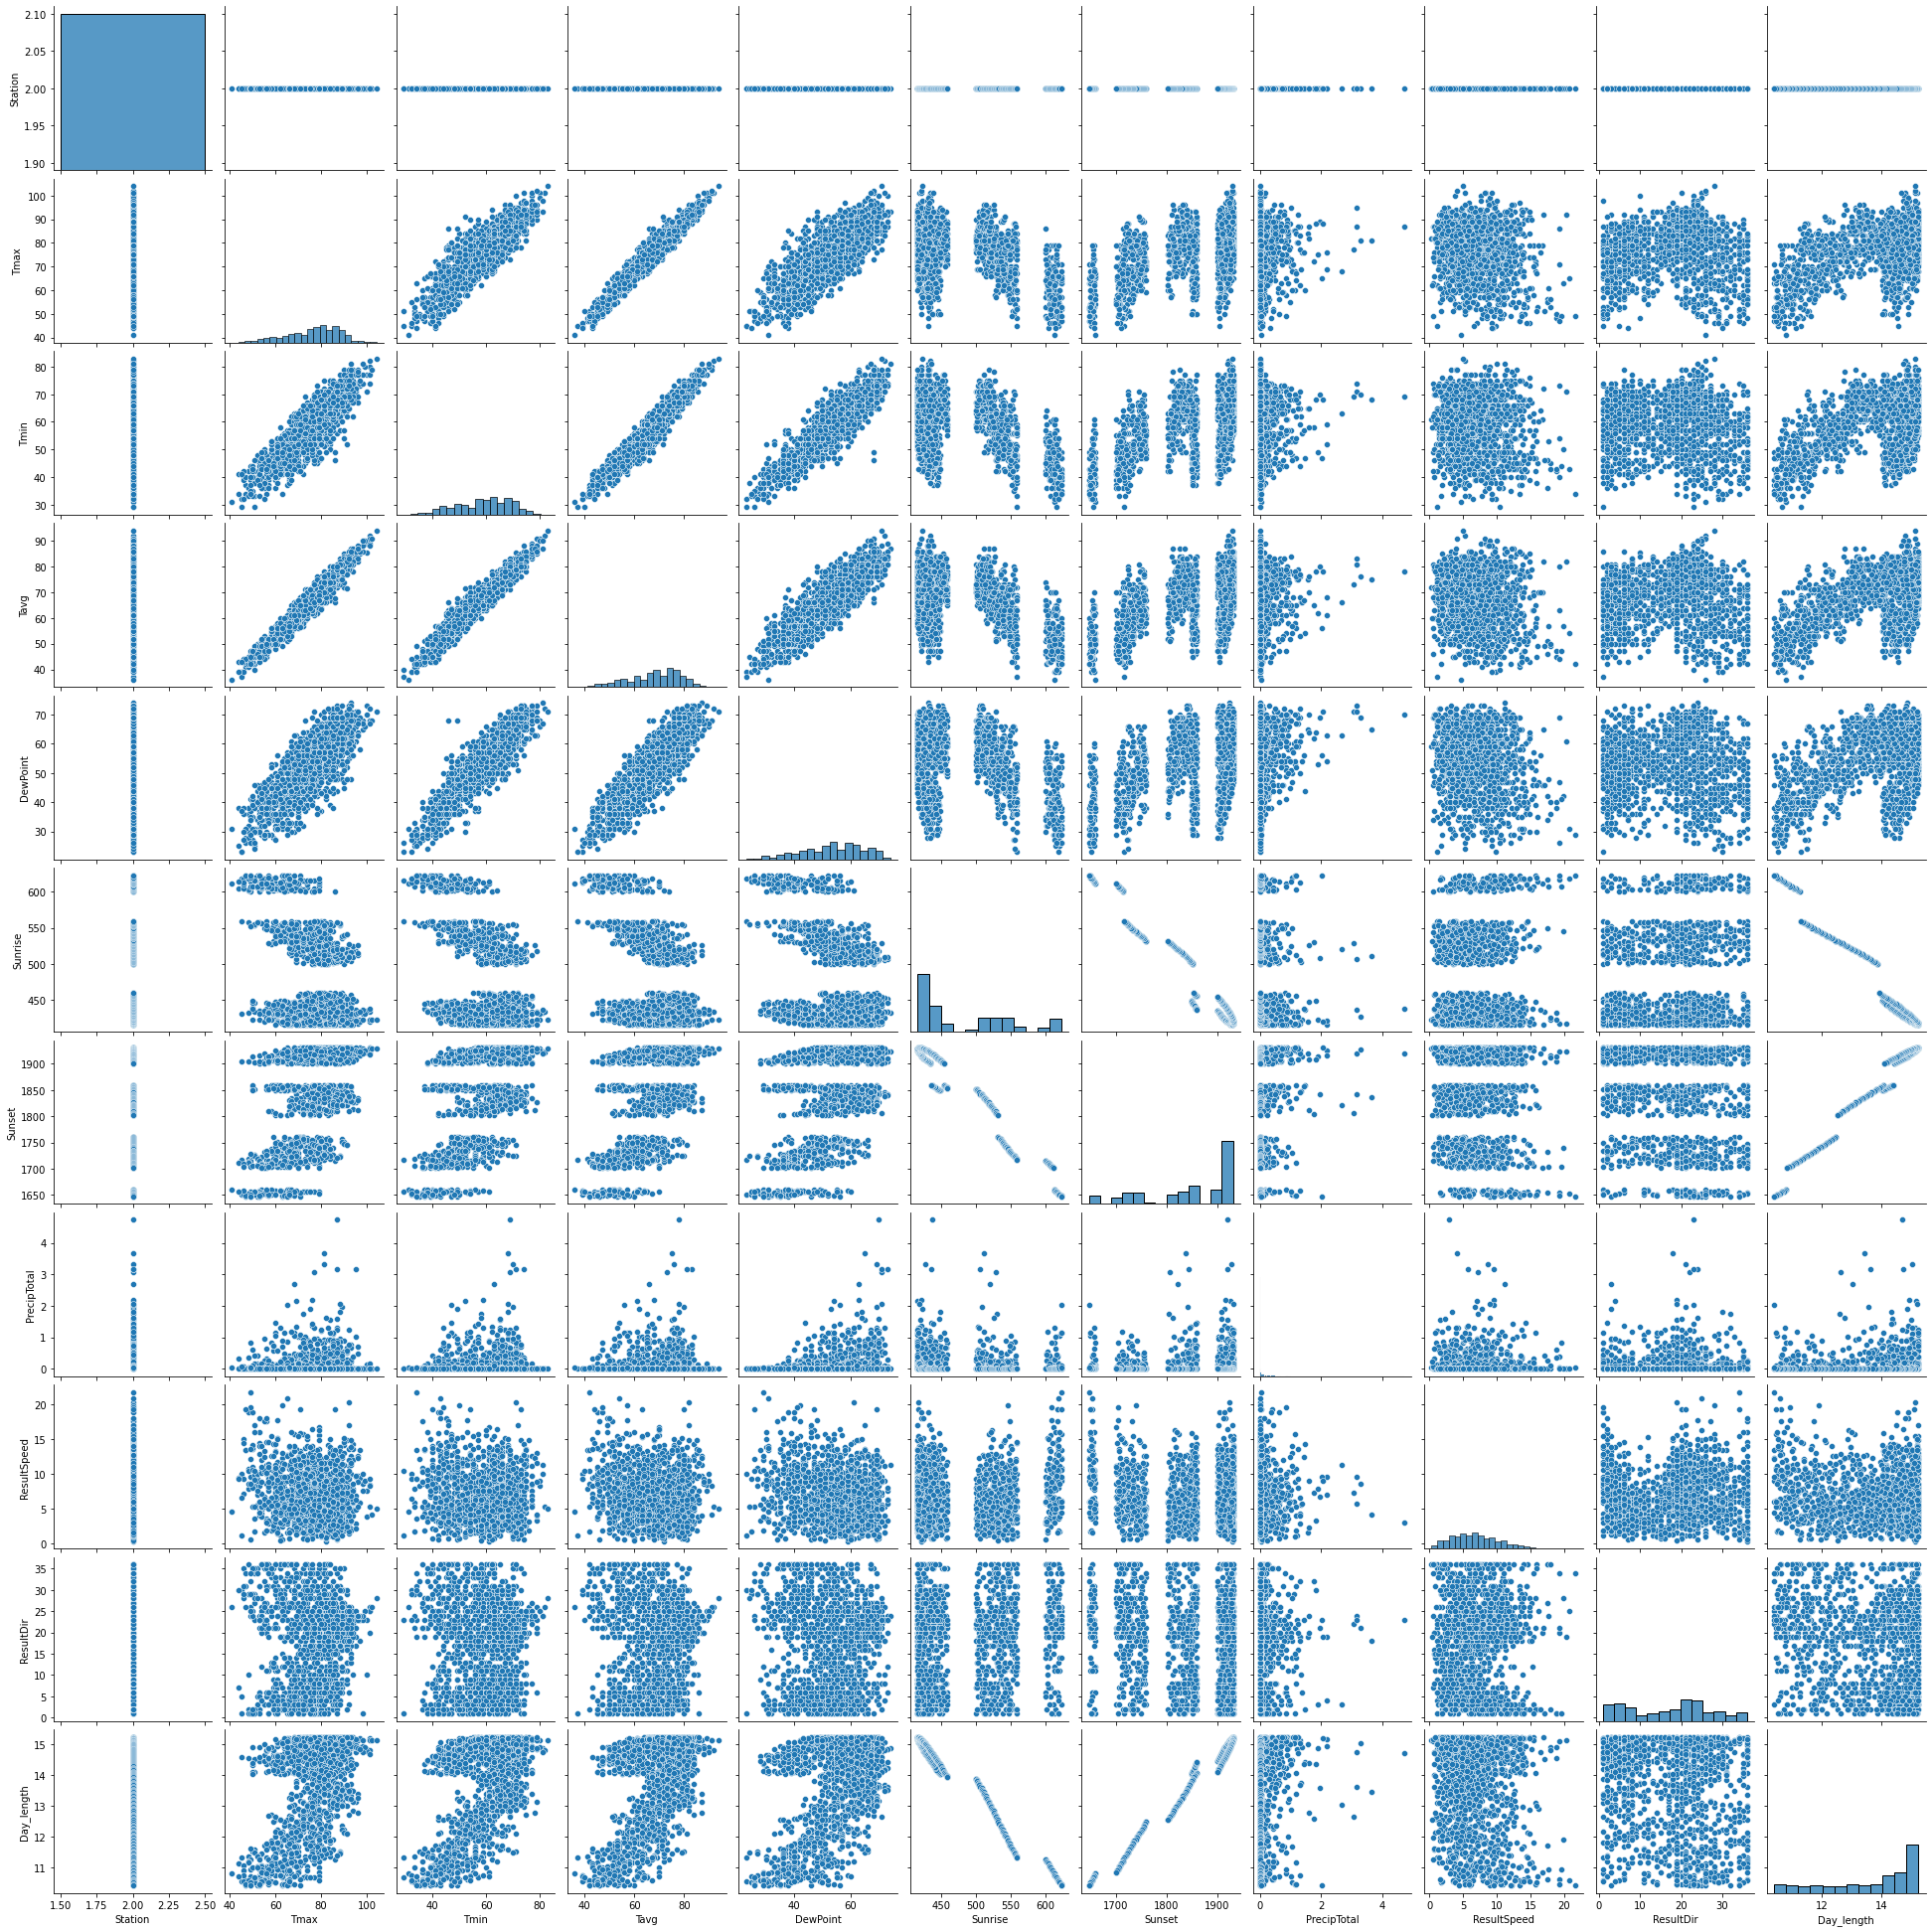

In [55]:
sns.pairplot(df_weather_2)

## Pickle

In [58]:
#save neccessary object to pickle_dict, which will be pickled in other notebook for feature engineering and modeling
#
pickle_dict1 = dict()
pickle_dict1['df_train']=df_train
pickle_dict1['df_test']=df_test
pickle_dict1['df_spray']=df_spray
pickle_dict1['df_weather_1']=df_weather_1
pickle_dict1['df_weather_2']=df_weather_2
pickle.dump(pickle_dict1, open('../assets/data1.pkl', 'wb'))